# Pytorch Autograd

Deep Learning means basically estimating some parameters set that would map a given input data distribution to a output distribution in an acceptable manner. No matter what the usecase is, in general sense this is what we try to achieve.

But as we know this require linear algebra and differenciation (means maths), and pytorch inherently support these mathematical operations.

To understand how these are working, lets check on a simple example.

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

Here assume we have a set of values `t_c` which should some how relate to another set of values `t_u`. Now our task is to identify the relationship between 2 such that if we have a `t_c` value we can predict the corresponding `t_u` value.

In [6]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

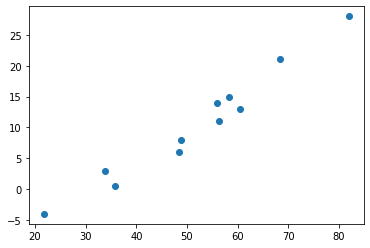

In [10]:
fig, ax = plt.subplots()
ax.scatter(t_u, t_c)
plt.show()

We can this linear model would fit here. So now what we do is basically try to fix a random linear model to this data and see how much error it would yield compared to actual data. From that error value we can identify how much we want to rectify our parameters.

In [12]:
def model(input_vals, w, b):
    return w*input_vals + b

def calc_error(pred_vals, true_vals):
    return ((pred_vals-true_vals)**2).mean() # Since we are using tensors, or we can use numpy functions here.

So now we have a model and a way to calculate errors. But to improve our model so that we can get lower error rate we need to do something else. Adjusting the weights based on the error values (backpropagation)